In [8]:
import pandas as pd
df=pd.read_parquet('/Users/wish.cha/Desktop/NEWS_task/cnbc_news_articles_20250515.parquet')
df.head(5)

,title,text,keyword,authors,publish_date,source
0,Thursday’s big stock stories: What’s likely to...,Stocks @ Night is a daily newsletter delivered...,risk,"['Jason Gewirtz', 'www.facebook.com']",2025-05-14 00:00:00,https://www.cnbc.com/2025/05/14/thursdays-big-...
1,Jim Cramer suggests why it's hard to own tradi...,CNBC's Jim Cramer reviewed why certain stocks ...,risk,"['Julie Coleman', 'www.facebook.com']",2025-05-14 00:00:00,https://www.cnbc.com/2025/05/14/jim-cramer-exp...
2,Denmark's economy boomed on drug exports — Tru...,Bloomberg | Bloomberg | Getty Images\n\nDenmar...,risk,"['Holly Ellyatt', 'www.facebook.com']",2025-05-15 00:00:00,https://www.cnbc.com/2025/05/15/trumps-pharma-...
3,Trump’s push to break China’s mineral dominanc...,Pallava Bagla | Corbis News | Getty Images\n\n...,risk,"['Sam Meredith', 'www.facebook.com']",2025-05-15 00:00:00,https://www.cnbc.com/2025/05/15/trumps-critica...
4,Steve Cohen says stocks could retest their Apr...,Steve Cohen said Wednesday he sees the possibi...,risk,"['Yun Li', 'www.facebook.com']",2025-05-14 00:00:00,https://www.cnbc.com/2025/05/14/steve-cohen-sa...


In [9]:
len(df)

3630

In [ ]:
%pip install fastparquet pyarrow scikit-learn openai python-dotenv seaborn matplotlib tiktoken

In [14]:
import os
import pandas as pd
import numpy as np
from openai import AzureOpenAI
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

/Users/wish.cha/Desktop/NEWS_clusters2/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Successfully loaded data from cnbc_news_articles_20250515.parquet. Shape: (3630, 6)

Generating embeddings...
Generated 3629 embeddings with dimension 3072

Performing KMeans clustering with 4 clusters...

Clustering Results (Sample Texts per Cluster):

--- Cluster 0 ---
- Pallava Bagla | Corbis News | Getty Images

U.S. President Donald Trump's critical minerals drive looks set to pave the way for a gold rush on the oce...
- Nvidia announced an agreement with Saudi Arabia on Tuesday to develop the kingdom's artificial intelligence capabilities, a sign of its expanding glob...
- Hitting a six-figure salary is a major career benchmark in the U.S., but $100,000 doesn't buy what it used to.

In fact, it won't pay for a median-pri...
- At age 7, Simone Biles watched a cheerleader complete a standing back tuck, then confidently told her coach she could do one, too. She tried one and l...
- Ford Motor is recalling 273,789 vehicles in the United States as a loss of brake function may increase

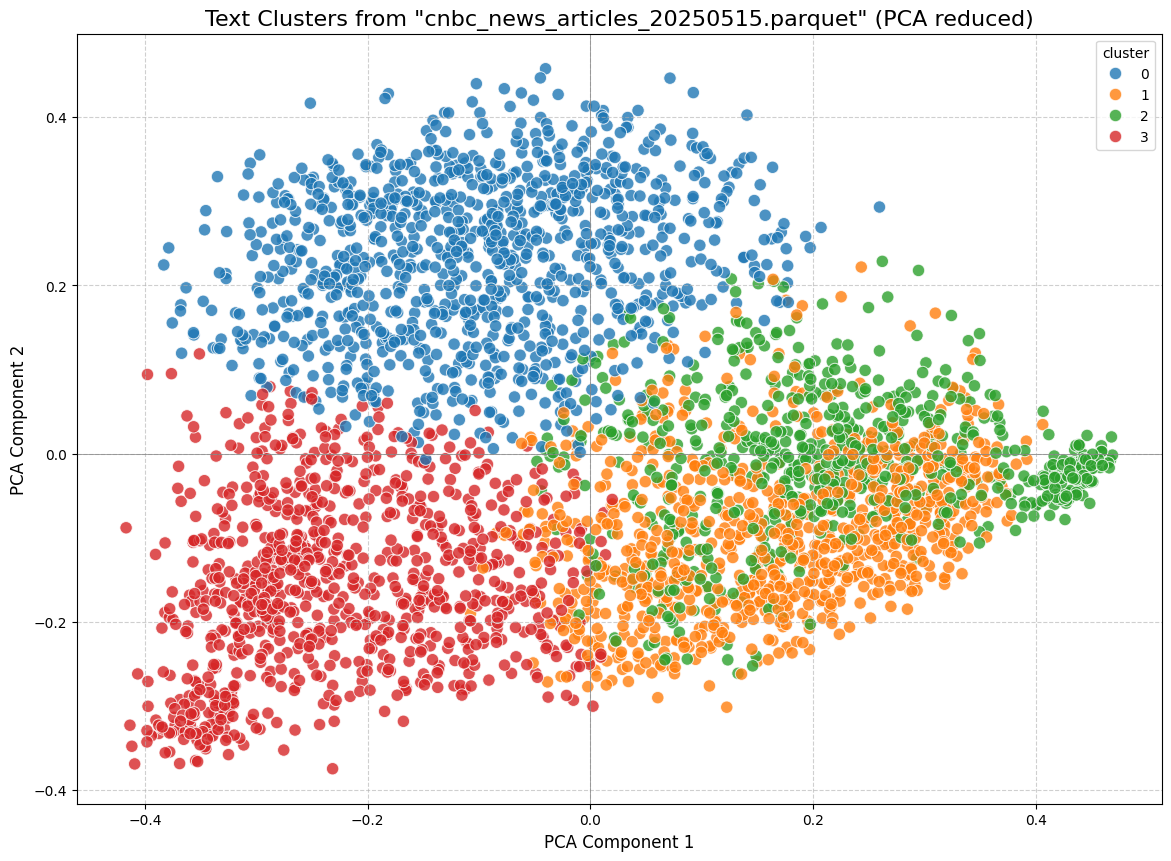


Note: Each point on the plot represents a news article, colored by its assigned cluster.

Original Data with Cluster Assignments (first 5 rows):
                                                text  cluster
0  Stocks @ Night is a daily newsletter delivered...        1
1  CNBC's Jim Cramer reviewed why certain stocks ...        1
2  Bloomberg | Bloomberg | Getty Images\n\nDenmar...        3
3  Pallava Bagla | Corbis News | Getty Images\n\n...        0
4  Steve Cohen said Wednesday he sees the possibi...        3


In [10]:
from dotenv import load_dotenv
import tiktoken 


load_dotenv()

try:
    api_key = os.environ.get("AZURE_OPENAI_API_KEY")
    azure_endpoint = os.environ.get("AZURE_OPENAI_ENDPOINT")
    
    embedding_deployment_name = os.environ.get("AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME")
    
    api_version = os.environ.get("AZURE_OPENAI_API_VERSION")

    if not all([api_key, azure_endpoint, embedding_deployment_name, api_version]):
        raise ValueError(
            "Please ensure AZURE_OPENAI_API_KEY, AZURE_OPENAI_ENDPOINT, "
            "AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME, and AZURE_OPENAI_API_VERSION "
            "are set in your .env file."
        )

except Exception as e:
    print(f"Error loading environment variables: {e}")
    print("Please check your .env file for the required Azure OpenAI credentials.")
    raise 

client = AzureOpenAI(
    api_key=api_key,
    azure_endpoint=azure_endpoint,
    api_version=api_version,
)

# ประกาศ encoding สำหรับ tiktoken ไว้นอกฟังก์ชัน เพื่อประสิทธิภาพ
# สำหรับ text-embedding-3-large ให้ใช้ 'cl100k_base'
# ตรวจสอบ: pip install tiktoken
try:
    encoding = tiktoken.get_encoding("cl100k_base")
except Exception as e:
    print(f"Error loading tiktoken encoding: {e}")
    print("Please ensure 'tiktoken' is installed (pip install tiktoken) and the encoding name is correct.")
    raise

parquet_file_path = "/Users/wish.cha/Desktop/NEWS_task/cnbc_news_articles_20250515.parquet"
text_column_name = "text"

try:
    df = pd.read_parquet(parquet_file_path)
    print(f"Successfully loaded data from {os.path.basename(parquet_file_path)}. Shape: {df.shape}")

    if text_column_name not in df.columns:
        raise ValueError(f"Column '{text_column_name}' not found in the parquet file.")
    
    # Check NAN
    df.dropna(subset=[text_column_name], inplace=True)
    if df.empty:
        raise ValueError(f"No valid text found in column '{text_column_name}' after dropping NaN values.")

except FileNotFoundError:
    print(f"Error: Parquet file not found at {parquet_file_path}.")
    print("Please ensure the file path is correct.")
    raise 
except Exception as e:
    print(f"An error occurred while reading the parquet file: {e}")
    raise 

# embedding
def get_embedding(text, model=embedding_deployment_name, dimensions=None, max_tokens=8192):
    """
    Generate an embedding for the given text using Azure OpenAI.
    Handles text truncation to fit the model's max_tokens limit.
    Optionally specify the number of dimensions for the embedding.
    """
    if pd.isna(text) or not text:
        return None

    
    # tiktoken to change to token
    tokens = encoding.encode(text)
    
    if len(tokens) > max_tokens:
        truncated_tokens = tokens[:max_tokens]
        text = encoding.decode(truncated_tokens)
        # print(f"Warning: Truncated text (from {len(tokens)} to {max_tokens} tokens) for embedding.")

    try:
        if dimensions:
            response = client.embeddings.create(input=[text], model=model, dimensions=dimensions)
        else:
            response = client.embeddings.create(input=[text], model=model)
        return response.data[0].embedding
    except Exception as e:
        
        print(f"Error getting embedding for '{text[:200]}...': {e}")
        return None

print("\nGenerating embeddings...")
desired_dimensions = None 


df['embedding'] = df[text_column_name].apply(lambda x: get_embedding(x, dimensions=desired_dimensions))

# 4. case Embedding failed
original_rows = len(df)
df.dropna(subset=['embedding'], inplace=True)
if len(df) < original_rows:
    print(f"Dropped {original_rows - len(df)} rows due to missing or failed embeddings.")

if df.empty:
    print("No valid embeddings generated after processing. Please check your data or API calls.")
    raise ValueError("Cannot proceed without valid embeddings.") 

# 5. Prepare data to  Clustering
embeddings = np.array(df['embedding'].tolist())
print(f"Generated {len(embeddings)} embeddings with dimension {embeddings.shape[1]}")

# 6.  Clustering (KMeans) 

n_clusters = 4
print(f"\nPerforming KMeans clustering with {n_clusters} clusters...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) 
df['cluster'] = kmeans.fit_predict(embeddings)

print("\nClustering Results (Sample Texts per Cluster):")
for i in range(n_clusters):
    print(f"\n--- Cluster {i} ---")
    # example 5 list
    cluster_texts = df[df['cluster'] == i][text_column_name].head(5).tolist()
    if cluster_texts:
        for j, text in enumerate(cluster_texts):
            print(f"- {text[:150]}...")
    else:
        print("- No texts in this cluster.")

# 7.PCA 
if embeddings.shape[1] > 2:
    pca = PCA(n_components=2, random_state=42)
    embeddings_2d = pca.fit_transform(embeddings)
    df['pca_x'] = embeddings_2d[:, 0]
    df['pca_y'] = embeddings_2d[:, 1]

    plt.figure(figsize=(14, 10)) 
    sns.scatterplot(
        x='pca_x',
        y='pca_y',
        hue='cluster',
        palette='tab10',
        data=df,
        legend='full',
        s=80, 
        alpha=0.8 
    )

    plt.title(f'Text Clusters from "{os.path.basename(parquet_file_path)}" (PCA reduced)', fontsize=16)
    plt.xlabel('PCA Component 1', fontsize=12)
    plt.ylabel('PCA Component 2', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.axhline(0, color='grey', linewidth=0.5) 
    plt.axvline(0, color='grey', linewidth=0.5)
    plt.show()

    print("\nNote: Each point on the plot represents a news article, colored by its assigned cluster.")
    print("\nOriginal Data with Cluster Assignments (first 5 rows):")
    print(df[[text_column_name, 'cluster']].head())
else:
    print("\nEmbeddings already have 2 or fewer dimensions, no PCA needed for visualization.")